# Code generation with RAG and self-correction

AlphaCodium presented an approach for code generation that uses control flow.

Main idea: [construct an answer to a coding question iteratively.](https://x.com/karpathy/status/1748043513156272416?s=20). 

[AlphaCodium](https://github.com/Codium-ai/AlphaCodium) iteravely tests and improves an answer on public and AI-generated tests for a particular question. 

We will implement some of these ideas from scratch using [LangGraph](https://langchain-ai.github.io/langgraph/):

1. We start with a set of documentation specified by a user
2. We use a long context LLM to ingest it and perform RAG to answer a question based upon it
3. We will invoke a tool to produce a structured output
4. We will perform two unit tests (check imports and code execution) prior returning the solution to the user 

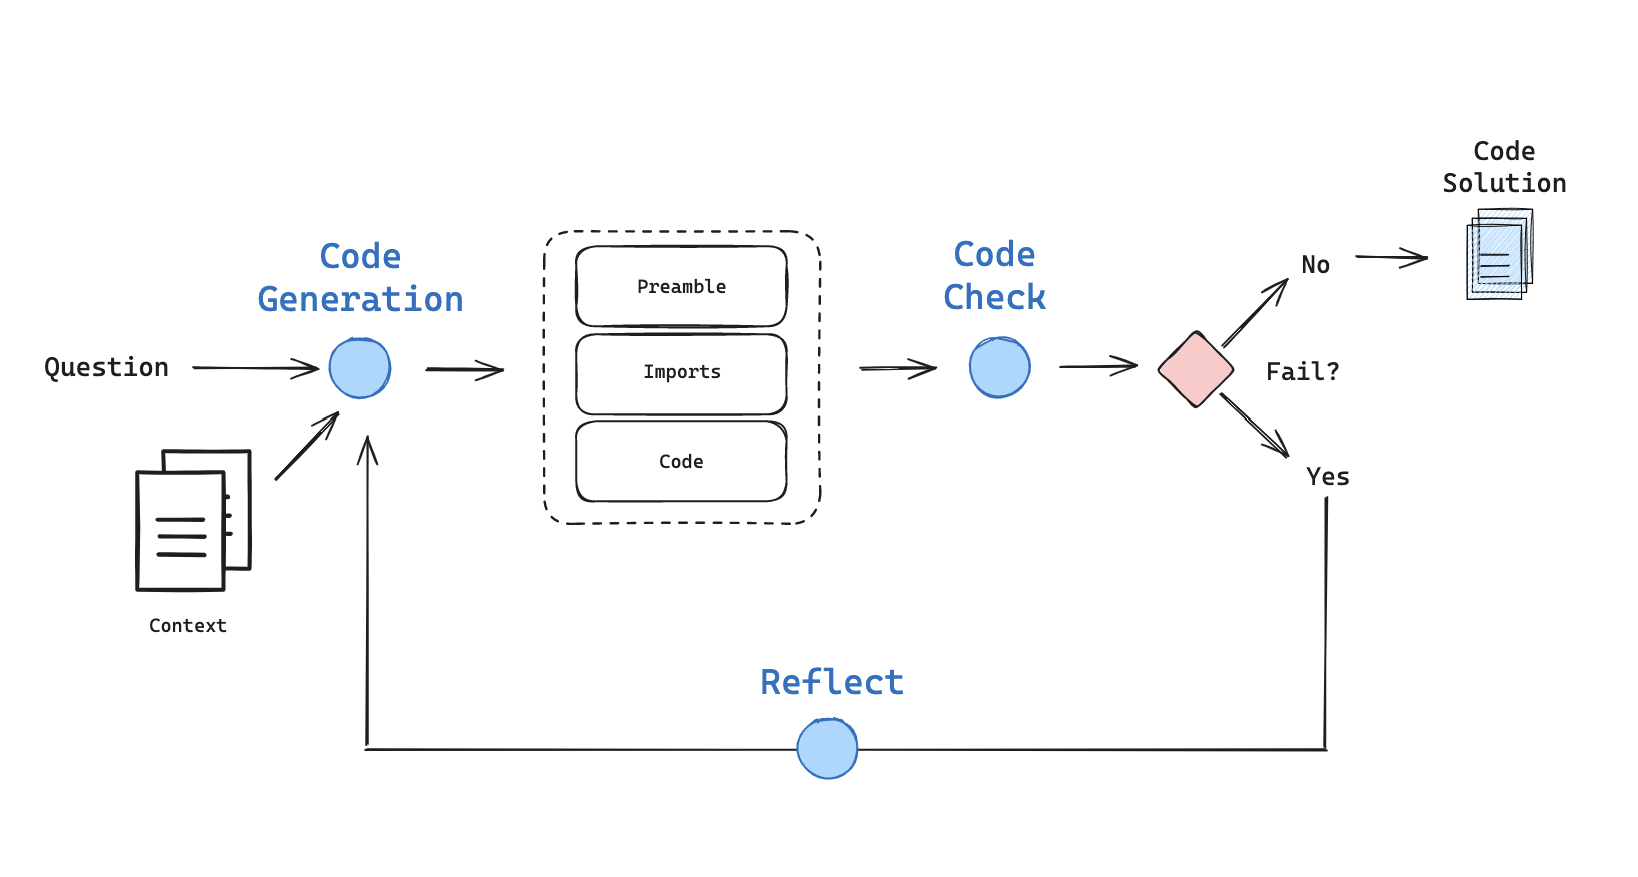

## Setup

First, let's install our required packages and set the API keys we will need

In [1]:
#! uv pip install -U langchain_community langchain-groq groq langchain langgraph bs4 

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("GROQ_API_KEY")
_set_env("TAVILY_API_KEY")
#_set_env("ANTHROPIC_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Docs

Load [LangChain Expression Language](https://python.langchain.com/docs/concepts/#langchain-expression-language-lcel) (LCEL) docs as an example.

In [ ]:
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# LCEL docs
url = "https://python.langchain.com/docs/concepts/lcel/"

loader = RecursiveUrlLoader(
    url=url, max_depth=2, extractor=lambda x: Soup(x, "html.parser").text
)

docs = loader.load()

In [4]:
docs

[Document(metadata={'source': 'https://python.langchain.com/docs/concepts/lcel/', 'content_type': 'text/html; charset=utf-8', 'title': 'LangChain Expression Language (LCEL) | 🦜️🔗 LangChain', 'description': '* Runnable Interface', 'language': 'en'}, page_content='\n\n\n\n\nLangChain Expression Language (LCEL) | 🦜️🔗 LangChain\n\n\n\n\n\n\n\n\nSkip to main contentOur new LangChain Academy Course Deep Research with LangGraph is now live! Enroll for free.IntegrationsAPI ReferenceMoreContributingPeopleError referenceLangSmithLangGraphLangChain HubLangChain JS/TSv0.3v0.3v0.2v0.1💬SearchIntroductionTutorialsBuild a Question Answering application over a Graph DatabaseTutorialsBuild a simple LLM application with chat models and prompt templatesBuild a ChatbotBuild a Retrieval Augmented Generation (RAG) App: Part 2Build an Extraction ChainBuild an AgentTaggingBuild a Retrieval Augmented Generation (RAG) App: Part 1Build a semantic search engineBuild a Question/Answering system over SQL dataSummari

In [5]:
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader
import re

def bs4_extractor(html: str) -> str:
    soup = Soup(html, "lxml")
    return re.sub(r"\n\n+", "\n\n", soup.text).strip()

# LCEL docs
url = "https://python.langchain.com/docs/concepts/lcel/"
loader = RecursiveUrlLoader(
    url=url, 
    max_depth=2, 
    extractor=bs4_extractor #lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# Sort the list based on the URLs and get the text
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)

C:\Users\jefer\AppData\Local\Temp\ipykernel_36152\3705520938.py:6: XMLParsedAsHTMLWarning: It looks like you're using an HTML parser to parse an XML document.

Assuming this really is an XML document, what you're doing might work, but you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the Python package 'lxml' installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.

If you want or need to use an HTML parser on this document, you can make this warning go away by filtering it. To do that, run this code before calling the BeautifulSoup constructor:

    from bs4 import XMLParsedAsHTMLWarning
    import warnings

    warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

  soup = Soup(html, "lxml")


In [27]:
from langchain_tavily import TavilySearch

tool = TavilySearch(
    max_results=5,
    topic="general",
    # include_answer=False,
    # include_raw_content=False,
    # include_images=False,
    # include_image_descriptions=False,
    # search_depth="basic",
    # time_range="day",
    # include_domains=None,
    exclude_domains=["medium.com", "youtube.com", "wikipedia.org", "linkedin.com"],
)

In [28]:
from typing import List, Dict, Any
from pydantic import BaseModel
from langchain_tavily import TavilySearch

class PesquisaTavily(BaseModel):
    query: str
    urls : List[str]
    title: List[str]
    content: List[str] 
    score : List[float]  
    content_join : str
    
    
class DadosPesquisaTavily:
    def __init__(self, query: str, 
                 topic: str = "general", 
                 max_results: int = 5, 
                 exclude_domains: List[str] = ["medium.com", "youtube.com", "wikipedia.org", "linkedin.com"]) -> None:
        self.query = query
        self.topic = topic
        self.max_results = max_results
        self.exclude_domains = exclude_domains
    
    def pesquisa_tavily(self) -> Dict[str, Any]:
        
        tool = TavilySearch(
            max_results=self.max_results,
            topic=self.topic,
            exclude_domains=self.exclude_domains,
        )
        return tool.run(self.query)
       
    def instancia_pesquisa_tavily(self) -> PesquisaTavily:
        response = self.pesquisa_tavily()
        return PesquisaTavily(
            query=response['query'],
            urls=[result['url'] for result in response['results']],
            title=[result['title'] for result in response['results']],
            content=[result['content'] for result in response['results']],
            score=[result['score'] for result in response['results']],
            content_join= "\n\n".join(result['content'] for result in response['results']),
        )
        
        

        


In [29]:
tavily = DadosPesquisaTavily(query="How do I build a RAG with LangChain?")
pesquisa_tavily_instance = tavily.instancia_pesquisa_tavily()

In [30]:
pesquisa_tavily_instance

PesquisaTavily(query='How do I build a RAG with LangChain?', urls=['https://python.langchain.com/docs/tutorials/rag/', 'https://www.reddit.com/r/LangChain/comments/1k6p59i/any_good_and_easy_tutorial_on_how_to_build_a_rag/', 'https://realpython.com/build-llm-rag-chatbot-with-langchain/', 'https://machinelearningmastery.com/a-practical-guide-to-building-local-rag-applications-with-langchain/', 'https://python.langchain.com/docs/tutorials/qa_chat_history/'], title=['Build a Retrieval Augmented Generation (RAG) App: Part 1', 'Any good and easy tutorial on how to build a RAG? - Reddit', 'Build an LLM RAG Chatbot With LangChain - Real Python', 'A Practical Guide to Building Local RAG Applications with LangChain', 'Build a Retrieval Augmented Generation (RAG) App: Part 2'], content=['Make sure that every detail of the architecture is, in the end, implemented as code.\\\\nMake sure that every detail of the architecture is, in the end, implemented as code.\\\\n\\\\nThink step by step and reason

In [31]:
def dados_tool(query: str) -> str:
    """Executes a data search using the Tavily tool.

    This function acts as a wrapper to perform a web search
    using the Tavily API. It initializes a search with the
    provided query, processes the response, and returns the content of the 
    results found as a single, concatenated string.

    Args:
        query (str): The search query to be sent to the Tavily API.

    Returns:
        str: A string containing the joined content of the search results.
    """
    
    tavily = DadosPesquisaTavily(query=query)
    response = tavily.instancia_pesquisa_tavily()
    return response.content_join
    

In [32]:
dados_tool("How can I directly pass a string to a runnable and use it to construct the input needed for my prompt, Used the ChatGroq da langchain?")

'* Coercion of custom functions into runnables when used in chains import { StringOutputParser } from "@langchain/core/output_parsers"; import  { StringOutputParser }  from  "@langchain/core/output_parsers"; import { ChatPromptTemplate } from "@langchain/core/prompts"; import  { ChatPromptTemplate }  from  "@langchain/core/prompts"; import { RunnableLambda } from "@langchain/core/runnables"; import  { RunnableLambda }  from  "@langchain/core/runnables"; import { ChatOpenAI } from "@langchain/openai"; import  { ChatOpenAI }  from  "@langchain/openai";  const lengthFunction = (input: { foo: string }): { length: string } => { const  lengthFunction =  (input:  { foo:  string  }):  { length:  string  }  =>  {  return {  return  {    length: input.foo.length.toString(),     length:  input. import { type RunnableConfig } from "@langchain/core/runnables"; import  { type  RunnableConfig  }  from  "@langchain/core/runnables";  const echo = (text: string, config: RunnableConfig) => { const  echo 

## LLMs

### Code solution

First, we will try OpenAI and [Claude3](https://python.langchain.com/docs/integrations/providers/anthropic/) with function calling.

We will create a `code_gen_chain` w/ either OpenAI or Claude and test them here.

<div class="admonition note">
    <p class="admonition-title">Using Pydantic with LangChain</p>
    <p>
        This notebook uses Pydantic v2 <code>BaseModel</code>, which requires <code>langchain-core >= 0.3</code>. Using <code>langchain-core < 0.3</code> will result in errors due to mixing of Pydantic v1 and v2 <code>BaseModels</code>.
    </p>
</div>

In [34]:
from langchain_core.prompts import ChatPromptTemplate
#from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq

### OpenAI

# Grader prompt
code_gen_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a coding assistant with expertise in LCEL, LangChain expression language. \n 
    Here is a full set of LCEL documentation:  \n ------- \n  {context} \n ------- \n Answer the user 
    question based on the above provided documentation. Ensure any code you provide can be executed \n 
    with all required imports and variables defined. Structure your answer with a description of the code solution. \n
    Then list the imports. And finally list the functioning code block. Here is the user question:""",
        ),
        ("placeholder", "{messages}"),
    ]
)


# Data model
class code(BaseModel):
    """Schema for code solutions to questions about LCEL."""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")


#expt_llm = "gpt-4o-mini"
#llm = ChatOpenAI(temperature=0, model=expt_llm)
llm = ChatGroq(temperature=0, 
               model="meta-llama/llama-4-maverick-17b-128e-instruct"
               #model="openai/gpt-oss-20b"
               )
code_gen_chain_oai = code_gen_prompt | llm.with_structured_output(code)
question = "How do I build a RAG chain in LCEL?"
solution_2 = code_gen_chain_oai.invoke(
    {
    #"context": concatenated_content, 
    "context": dados_tool(question),
     "messages": [("user", question)]
     }
)
solution_2

code(prefix='To build a RAG chain in LCEL, you need to create a chain that links the retriever, prompt template, and language model (llm) together.', imports='from langchain.prompts import PromptTemplate\nfrom langchain.chains import RunnableParallel, RunnableSequence\nfrom langchain.retrievers import Retriever\nfrom langchain.llms import LLM', code='rag_chain = ({\n        "context": retriever,\n        "question": RunnableParallel({"question": itemgetter("question")})\n    }\n    | prompt_template\n    | llm\n)\n\n# Invoke the chain on the \'question\' provided\nquestion = "your question here"\nresult = rag_chain.invoke({"question": question})')

In [35]:
solution_2.code.split("\n")

['rag_chain = ({',
 '        "context": retriever,',
 '        "question": RunnableParallel({"question": itemgetter("question")})',
 '    }',
 '    | prompt_template',
 '    | llm',
 ')',
 '',
 "# Invoke the chain on the 'question' provided",
 'question = "your question here"',
 'result = rag_chain.invoke({"question": question})']

In [36]:
solution_2.imports.split("\n")

['from langchain.prompts import PromptTemplate',
 'from langchain.chains import RunnableParallel, RunnableSequence',
 'from langchain.retrievers import Retriever',
 'from langchain.llms import LLM']

In [37]:
#from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate

### Anthropic

# Prompt to enforce tool use
code_gen_prompt_claude = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """<instructions> You are a coding assistant with expertise in LCEL, LangChain expression language. \n 
    Here is the LCEL documentation:  \n ------- \n  {context} \n ------- \n Answer the user  question based on the \n 
    above provided documentation. Ensure any code you provide can be executed with all required imports and variables \n
    defined. Structure your answer: 1) a prefix describing the code solution, 2) the imports, 3) the functioning code block. \n
    Invoke the code tool to structure the output correctly. </instructions> \n Here is the user question:""",
        ),
        ("placeholder", "{messages}"),
    ]
)


# LLM
"""expt_llm = "claude-3-opus-20240229"
llm = ChatAnthropic(
    model=expt_llm,
    default_headers={"anthropic-beta": "tools-2024-04-04"},
)"""

llm = ChatGroq(temperature=0, model="openai/gpt-oss-120b")

structured_llm_claude = llm.with_structured_output(code, include_raw=True)


# Optional: Check for errors in case tool use is flaky
def check_claude_output(tool_output):
    """Check for parse error or failure to call the tool"""

    # Error with parsing
    if tool_output["parsing_error"]:
        # Report back output and parsing errors
        print("Parsing error!")
        raw_output = str(tool_output["raw"].content)
        error = tool_output["parsing_error"]
        raise ValueError(
            f"Error parsing your output! Be sure to invoke the tool. Output: {raw_output}. \n Parse error: {error}"
        )

    # Tool was not invoked
    elif not tool_output["parsed"]:
        print("Failed to invoke tool!")
        raise ValueError(
            "You did not use the provided tool! Be sure to invoke the tool to structure the output."
        )
    return tool_output


# Chain with output check
code_chain_claude_raw = (
    code_gen_prompt_claude | structured_llm_claude | check_claude_output
)


def insert_errors(inputs):
    """Insert errors for tool parsing in the messages"""

    # Get errors
    error = inputs["error"]
    messages = inputs["messages"]
    messages += [
        (
            "assistant",
            f"Retry. You are required to fix the parsing errors: {error} \n\n You must invoke the provided tool.",
        )
    ]
    return {
        "messages": messages,
        "context": inputs["context"],
    }


# This will be run as a fallback chain
fallback_chain = insert_errors | code_chain_claude_raw
N = 3  # Max re-tries
code_gen_chain_re_try = code_chain_claude_raw.with_fallbacks(
    fallbacks=[fallback_chain] * N, exception_key="error"
)


def parse_output(solution):
    """When we add 'include_raw=True' to structured output,
    it will return a dict w 'raw', 'parsed', 'parsing_error'."""

    return solution["parsed"]


# Optional: With re-try to correct for failure to invoke tool
code_gen_chain = code_gen_chain_re_try | parse_output

# No re-try
code_gen_chain = code_gen_prompt_claude | structured_llm_claude | parse_output

In [38]:
# Test
question = "How do I build a RAG chain in LCEL?"
solution = code_gen_chain.invoke(
    {"context": dados_tool(question), "messages": [("user", question)]}
)
solution

code(prefix='Below is a minimal example that builds a Retrieval‑Augmented Generation (RAG) chain using LangChain Expression Language (LCEL). It assumes you already have a `retriever` (e.g., a VectorStoreRetriever), a `prompt_template` (a PromptTemplate that expects `{context}` and `{question}`), and an `llm` (an OpenAI or other LLM Runnable). The chain:\n1. Retrieves the top‑k documents for the incoming question.\n2. Formats the retrieved documents into a single string (`context`).\n3. Feeds `context` and the original `question` into the prompt template.\n4. Sends the rendered prompt to the LLM.\n5. Finally, we invoke the chain with a sample question.\n\nAll required imports are included, and the code can be run as‑is.', imports='from operator import itemgetter\nfrom langchain.schema.runnable import RunnableLambda, RunnablePassthrough\nfrom langchain.prompts import PromptTemplate\nfrom langchain.llms import OpenAI\n# If you need a retriever, e.g., from a vector store:\n# from langchain

In [39]:
solution.code.split("\n")

['# -------------------------------------------------',
 '# 1. Helper to turn a list of Document objects into a single string',
 '# -------------------------------------------------',
 'format_docs = RunnableLambda(lambda docs: "\\n\\n".join([d.page_content for d in docs]))',
 '',
 '# -------------------------------------------------',
 '# 2. Build the RAG chain using LCEL composition primitives',
 '# -------------------------------------------------',
 '# The input to the chain is a dict with a single key "question".',
 '# We first retrieve documents, format them, and then combine the',
 '# formatted context with the original question for the prompt.',
 'rag_chain = (',
 '    {',
 '        # Retrieve documents for the question',
 '        "docs": retriever | itemgetter("question"),',
 '        # Pass the original question through unchanged',
 '        "question": itemgetter("question"),',
 '    }',
 '    # Convert the list of Document objects to a string called "context"',
 '    | Run

In [40]:
solution.imports.split("\n")

['from operator import itemgetter',
 'from langchain.schema.runnable import RunnableLambda, RunnablePassthrough',
 'from langchain.prompts import PromptTemplate',
 'from langchain.llms import OpenAI',
 '# If you need a retriever, e.g., from a vector store:',
 '# from langchain.vectorstores import FAISS',
 '# from langchain.embeddings import OpenAIEmbeddings']

## State 

Our state is a dict that will contain keys (errors, question, code generation) relevant to code generation.

In [41]:
from typing import List
from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        error : Binary flag for control flow to indicate whether test error was tripped
        messages : With user question, error messages, reasoning
        generation : Code solution
        iterations : Number of tries
    """

    error: str
    messages: List
    generation: str
    iterations: int

## Graph 

Our graph lays out the logical flow shown in the figure above.

In [42]:
#!pip install -U -q open-deep-research

In [43]:
### Parameter

# Max tries
max_iterations = 3
# Reflect
# flag = 'reflect'
flag = "do not reflect"

### Nodes


def generate(state: GraphState):
    """
    Generate a code solution

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    error = state["error"]

    # We have been routed back to generation with an error
    if error == "yes":
        messages += [
            (
                "user",
                "Now, try again. Invoke the code tool to structure the output with a prefix, imports, and code block:",
            )
        ]

    # Solution
    code_solution = code_gen_chain.invoke(
        {"context": dados_tool(state['messages'][-1][1]), "messages": messages}
    )
    messages += [
        (
            "assistant",
            f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}",
        )
    ]

    # Increment
    iterations = iterations + 1
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


def code_check(state: GraphState):
    """
    Check code

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """

    print("---CHECKING CODE---")

    # State
    messages = state["messages"]
    code_solution = state["generation"]
    iterations = state["iterations"]

    # Get solution components
    imports = code_solution.imports
    code = code_solution.code

    # Check imports
    try:
        exec(imports)
    except Exception as e:
        print(f"---CODE IMPORT CHECK: FAILED--- {e} ")
        error_message = [("user", f"Your solution failed the import test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # Check execution
    try:
        exec(imports + "\n" + code)
    except Exception as e:
        print(f"---CODE BLOCK CHECK: FAILED--- {e}")
        error_message = [("user", f"Your solution failed the code execution test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # No errors
    print("---NO CODE TEST FAILURES---")
    return {
        "generation": code_solution,
        "messages": messages,
        "iterations": iterations,
        "error": "no",
    }


def reflect(state: GraphState):
    """
    Reflect on errors

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    code_solution = state["generation"]

    # Prompt reflection

    # Add reflection
    reflections = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    messages += [("assistant", f"Here are reflections on the error: {reflections}")]
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


### Edges


def decide_to_finish(state: GraphState):
    """
    Determines whether to finish.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations == max_iterations:
        print("---DECISION: FINISH---")
        return "end"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        if flag == "reflect":
            return "reflect"
        else:
            return "generate"

In [24]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("generate", generate)  # generation solution
workflow.add_node("check_code", code_check)  # check code
workflow.add_node("reflect", reflect)  # reflect

# Build graph
workflow.add_edge(START, "generate")
workflow.add_edge("generate", "check_code")
workflow.add_conditional_edges(
    "check_code",
    decide_to_finish,
    {
        "end": END,
        "reflect": "reflect",
        "generate": "generate",
    },
)
workflow.add_edge("reflect", "generate")
app = workflow.compile()

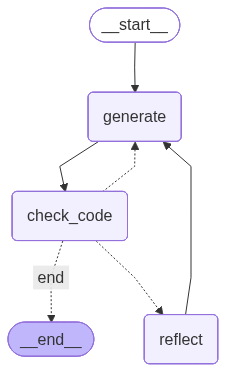

In [25]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [47]:
question = "How do I build a RAG chain in LCEL?"
solution = app.invoke({"messages": [("user", question)], "iterations": 0, "error": ""})

---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---


<string>:19: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.


---CHECKING CODE---
---CODE BLOCK CHECK: FAILED---
---DECISION: FINISH---


<string>:20: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.


In [48]:
solution['generation'].imports.split("\n")

['import os',
 'from operator import itemgetter',
 '',
 'from langchain.embeddings import HuggingFaceEmbeddings',
 'from langchain.vectorstores import FAISS',
 'from langchain.docstore.document import Document',
 'from langchain.prompts import PromptTemplate',
 'from langchain.schema.runnable import RunnableLambda',
 'from langchain.llms.fake import FakeListLLM']

In [49]:
solution['generation'].code.split("\n")

['# 1. Example documents',
 'texts = [',
 '    "Quantum computing leverages quantum bits, which can be in superposition, enabling massive parallelism.",',
 '    "One major challenge of quantum computing is error correction due to decoherence.",',
 '    "Scalable quantum hardware remains an engineering hurdle.",',
 '    "Quantum algorithms like Shor\'s algorithm can factor large numbers efficiently.",',
 ']',
 'documents = [Document(page_content=t) for t in texts]',
 '',
 '# 2. Local embedding model (no API key required)',
 'embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")',
 '',
 '# 3. Build a FAISS vector store and a retriever (top‑k = 2)',
 'vectorstore = FAISS.from_documents(documents, embeddings)',
 'retriever = vectorstore.as_retriever(search_kwargs={"k": 2})',
 '',
 "# 4. Prompt template expecting 'context' and 'question'",
 'prompt_template = PromptTemplate.from_template(',
 '    """You are a helpful AI assistant. Use the following context 

In [53]:
prompt = """ You are a coding assistant with expertise in LCEL, LangChain expression language. \n 
Here is the LCEL documentation:  \n ------- \n  {context} \n ------- \n Answer the user 
question based on the above provided documentation. Ensure any code you provide can be executed \n
{messages}
"""

print(prompt.format(context="ola", messages=[("user", question)]))

 You are a coding assistant with expertise in LCEL, LangChain expression language. 
 
Here is the LCEL documentation:  
 ------- 
  ola 
 ------- 
 Answer the user 
question based on the above provided documentation. Ensure any code you provide can be executed 

[('user', 'How do I build a RAG chain in LCEL?')]



## Eval

[Here](https://smith.langchain.com/public/326674a6-62bd-462d-88ae-eea49d503f9d/d) is a public dataset of LCEL questions. 

I saved this as `lcel-teacher-eval`.

You can also find the csv [here](https://github.com/langchain-ai/lcel-teacher/blob/main/eval/eval.csv).

In [19]:
import langsmith

client = langsmith.Client()

In [20]:
# Clone the dataset to your tenant to use it
try:
    public_dataset = (
        "https://smith.langchain.com/public/326674a6-62bd-462d-88ae-eea49d503f9d/d"
    )
    client.clone_public_dataset(public_dataset)
except:
    print("Please setup LangSmith")

Dataset(name='lcel-teacher-eval', description='Eval set for LCEL teacher', data_type=<DataType.kv: 'kv'>, id=UUID('8b57696d-14ea-4f00-9997-b3fc74a16846'), created_at=datetime.datetime(2024, 9, 16, 22, 50, 4, 169288, tzinfo=datetime.timezone.utc), modified_at=datetime.datetime(2024, 9, 16, 22, 50, 4, 169288, tzinfo=datetime.timezone.utc), example_count=0, session_count=0, last_session_start_time=None, inputs_schema=None, outputs_schema=None)

Custom evals.

In [21]:
from langsmith.schemas import Example, Run


def check_import(run: Run, example: Example) -> dict:
    imports = run.outputs.get("imports")
    try:
        exec(imports)
        return {"key": "import_check", "score": 1}
    except Exception:
        return {"key": "import_check", "score": 0}


def check_execution(run: Run, example: Example) -> dict:
    imports = run.outputs.get("imports")
    code = run.outputs.get("code")
    try:
        exec(imports + "\n" + code)
        return {"key": "code_execution_check", "score": 1}
    except Exception:
        return {"key": "code_execution_check", "score": 0}

Compare LangGraph to Context Stuffing.

In [33]:
def predict_base_case(example: dict):
    """Context stuffing"""
    solution = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": [("user", example["question"])]}
    )
    return {"imports": solution.imports, "code": solution.code}


def predict_langgraph(example: dict):
    """LangGraph"""
    graph = app.invoke(
        {"messages": [("user", example["question"])], "iterations": 0, "error": ""}
    )
    solution = graph["generation"]
    return {"imports": solution.imports, "code": solution.code}

In [34]:
from langsmith.evaluation import evaluate

# Evaluator
code_evalulator = [check_import, check_execution]

# Dataset
dataset_name = "lcel-teacher-eval"

In [ ]:
# Run base case
try:
    experiment_results_ = evaluate(
        predict_base_case,
        data=dataset_name,
        evaluators=code_evalulator,
        experiment_prefix=f"test-without-langgraph-{expt_llm}",
        max_concurrency=2,
        metadata={
            "llm": expt_llm,
        },
    )
except:
    print("Please setup LangSmith")

In [ ]:
# Run with langgraph
try:
    experiment_results = evaluate(
        predict_langgraph,
        data=dataset_name,
        evaluators=code_evalulator,
        experiment_prefix=f"test-with-langgraph-{expt_llm}-{flag}",
        max_concurrency=2,
        metadata={
            "llm": expt_llm,
            "feedback": flag,
        },
    )
except:
    print("Please setup LangSmith")

`Results:`

* `LangGraph outperforms base case`: adding re-try loop improve performance
* `Reflection did not help`: reflection prior to re-try regression vs just passing errors directly back to the LLM
* `GPT-4 outperforms Claude3`: Claude3 had 3 and 1 run fail due to tool-use error for Opus and Haiku, respectively

https://smith.langchain.com/public/78a3d858-c811-4e46-91cb-0f10ef56260b/d